In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
xp = open("X.pickle","rb")
yp = open("Y.pickle","rb")
x = pickle.load(xp)
y = pickle.load(yp)
xp.close()
yp.close()
D_model = keras.Sequential([
    Input(shape=(230)),
    Dense(230, activation="relu"),
    Dense(115, activation="relu"),
    Dense(1, activation="sigmoid")
], name="discriminator")
G_model = keras.Sequential([
    Input(shape=(20,230)),
    Dense(230, activation="relu"),
    Flatten(),
    Dense(250, activation="relu"),
    Dense(230, activation="sigmoid"),
], name="generator")
class GAN(keras.Model):
    def __init__(self,discriminator, generator, xs):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.xs = xs
    def compile(self, d_op, g_op, loss_fn):
        super().compile()
        self.d_optimizer = d_op
        self.g_optimizer = g_op
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    def train_step(self, real):
        batch_size = tf.shape(real)[0]
        generated = self.generator(tf.gather(self.xs,tf.random.uniform(minval=0,maxval=self.xs.shape[0], shape=[batch_size], dtype=tf.int32)))
        print(generated)
        combined_images = tf.concat([generated, real], axis=0)
        labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))], axis=0)
        labels+= 0.05* tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels,predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        random_samples = tf.gather(self.xs,tf.random.uniform(minval=0,maxval=self.xs.shape[0], shape=[batch_size], dtype=tf.int32))
        misleading_labels = tf.zeros((batch_size,1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_samples))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return{
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
gan = GAN(discriminator=D_model, generator=G_model, xs=tf.convert_to_tensor(x, dtype=tf.float32))
gan.compile(
    d_op=keras.optimizers.Adam(learning_rate=0.0001),
    g_op=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [4]:
#for some reason this stop the error in load_weights
gan.built = True
#load weights
gan.load_weights("gan.hdf5")

In [9]:
#start withs some samples
sample = x[0]
#create more samples
for i in range(100):
    sample = np.concatenate((sample,G_model([sample[i:i+20].reshape(1,20,230)])), axis=0)

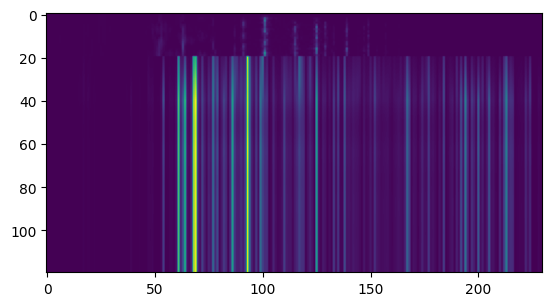

In [6]:
plt.imshow(sample)
plt.show()

In [ ]:
#postproccess the image and save
sample = cv2.rotate(sample,cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.imwrite('sample.bmp', sample*255.0)